In [42]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
from ugradio import doppler
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from astropy.io import fits
import astropy
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.signal import argrelmax
from scipy.stats import norm
from astropy import modeling
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import interpolate
import astropy.time
import time
from matplotlib.patches import Rectangle
import scipy
from scipy.signal import find_peaks

In [9]:
cd ../../

/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4


In [14]:
phases = ['/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042424/Phase1', '/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042424/Phase2',
          '/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042524']
files = [file for directory in phases for file in glob.glob(f'{directory}/*.npz')]
table = pd.read_csv('Leusch_Stuff/RA_Sorted.csv')

leusch_data = sorted(files, key=lambda x: np.load(x)['coords'][5])

noises = glob.glob('/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042424/Noise_Spectra/*.npz')

gain0_spec = np.load('/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042424/Phase1/spec3_L134_B20.npz')
gain0_noise = np.load('/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042424/Noise_Spectra/NoiseSpec3_L134_B20.npz')

gain1_spec = np.load('/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042424/Phase2/spec167_L115_B47.npz')
gain1_noise = np.load('/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042424/Noise_Spectra/NoiseSpec167_L115_B47.npz')

gain1_spec = np.load('/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042424/Phase2/spec320_L111_B20.npz')
gain2_noise = np.load('/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042424/Noise_Spectra/NoiseSpec320_L111_B20.npz')

cal_data0 = np.load('/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042424/Noise_Spectra/NoiseSpec165_L111_B57.npz')['data0']
cold_data0 = np.load('/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042524/cold_spectra/coldspec.npz')['data0']

cal_data1 = np.load('/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042424/Noise_Spectra/NoiseSpec165_L111_B57.npz')['data1']
cold_data1 = np.load('/Users/hopediffenderfer/Desktop/ay121/FFC_folder/FFC_4/data/obs_042524/cold_spectra/coldspec.npz')['data1']


In [15]:
def shift(data):
    return np.fft.fftshift(data)

def gain(s_cal, s_cold):
    '''
    GET CALIBRATION DATA
    
    Params
    ------
    s_cal:  calibrated data, this is the data with noise diode turned on.
    s_cold: non-calibrated data, Leuschner pointed at arb. point.
    
    Output
    ------
    Gain calculated for Leuschner, we mult. all power spectra by this value.
    
    '''
    T_cal  = 50 # K
    T_cold = 2.73 # K
    
    difference = s_cal - s_cold
    G = ((T_cal - T_cold) / (np.sum(difference))) * np.sum(s_cold)
    return G

In [16]:
def T_power(line, G):
    '''This function calculates the intensity of the power spectrum
       given the spectrum and gain value.
       
       Params
       --------
       line: the spectrum we will multiply by the gain.
       G   : the gain of Leuschner 
       
       Output
       --------
       power: the final calibrated intensity of the object in
              units of temperature.
       '''
    intensity = line * G
    return intensity

In [17]:
N = len(leusch_data)

_cal0  = cal_data0 / N
_cold0 = cold_data0 / N

_cal1 = cal_data1 / N
_cold1 = cold_data1 / N

avg_calspec = (_cal0 + _cal1) / 2
avg_coldspec = (_cold0 + _cold1) / 2

G = gain(avg_calspec, avg_coldspec)
print(f'Gain: {G}')

Gain: 41.87120524585507


In [18]:
# make length object, empty arrays
len_testdata = len(leusch_data) 
pwr0 = [] 
pwr1 = []
unix = []
coordinates = []
alt_az = []
jd = []
galactic = []

# iterate through all 'testdata' object 
# grab info as well 
for n in range(len_testdata):
    test_dataFiles = np.load(leusch_data[n])
    # spectra 
    pwr0.append(test_dataFiles["data0"]) # Append data
    pwr1.append(test_dataFiles["data1"])
    unix.append(test_dataFiles['time'][()])
    coordinates.append(test_dataFiles['coords'])
    galactic.append([test_dataFiles['coords'][1], test_dataFiles['coords'][2]])
    jd.append(test_dataFiles['jd'])

In [19]:
# shift all da spectra

for i in range(len(pwr0)): 
    pwr0[i] = np.fft.fftshift(pwr0[i])

for i in range(len(pwr1)):
    pwr1[i] = np.fft.fftshift(pwr1[i])

In [20]:
freqs = 1420 + np.fft.fftshift(np.fft.fftfreq(len(pwr0[i]), 1/3.2))

In [21]:
'''
Here we determine the brightness temperature of all spectra
by multiplying all spectra by the gain.

Params
------
• spec_line: contains all original reduced noise spectra
• calibrated_spec: contains all calibrated spectra taking into account the gain, i.e. brightness temp
'''

cal_spec0 = []
cal_spec1 = []
for i in range(len(pwr0)):
    spectra0 = pwr0[i] * G
    spectra1 = pwr1[i] * G
    cal_spec0.append(spectra0) # brightness temp [K]
    cal_spec1.append(spectra1)

In [22]:
# this is a loop to do that S-line division to all of the power spectra

divided0 = [] 
chunked0 = []
freqs_chunked0 = []
for i in range(len(pwr0)):
    spectra = pwr0[i]
    switch_set = spectra[0:1024] 
    switched = np.flip(switch_set)
    flatter = spectra[1024:2048]/switched
    chunked = flatter[5:600]
    freq_divided = freqs[1024:2048]
    freq_chunked_axis = freq_divided[5:600]
    divided0.append(flatter)
    chunked0.append(chunked)
    freqs_chunked0.append(freq_chunked_axis)


divided1 = []
chunked1 = []
freqs_chunked1 = []
for i in range(len(pwr1)):
    spectra = pwr1[i]
    switch_set = spectra[0:1024] 
    switched = np.flip(switch_set)
    flatter = spectra[1024:2048]/switched
    chunked = flatter[50:600]
    freq_divided = freqs[1024:2048]
    freq_chunked_axis = freq_divided[5:600]
    divided1.append(flatter)
    chunked1.append(chunked)
    freqs_chunked1.append(freq_chunked_axis)

# in these loops, once we find gain, we can just multiply 
# the new T-line spectra (the "flatter" and "chunked") by that gain value

In [30]:
ind = []
freq_peak = []
freq_divided = freqs[1024:2048]
freq_chunked = freq_divided[5:600]


for i in range(len(chunked0)):
    if 0 < i < 180 & 223 < i < 312:
        index = np.nanargmax(chunked0[i])
        ind.append(index)
        freq_peak.append(freq_chunked[index])
    else: 
        special_chunk = chunked0[i][200:450]
        freq_special = freq_chunked[200:450]
        index_special = np.nanargmax(special_chunk)
        ind.append(index_special)
        freq_peak.append(freq_chunked[index_special])
        
freq_arr = np.array(freq_peak)

In [83]:
c = 299792458

velocity_peak = []
freqs_dopp = []
velocity_peak_kms = []

for i in range(len(freq_arr)):
    RA = coordinates[i][3]
    DEC = coordinates[i][4]
    jd_i = jd[i]
    LSR_target_vel = doppler.get_projected_velocity(ra = RA, dec = DEC, jd = jd_i)
    nu = 1420.405
    delta_nu = freq_arr[i] - nu
    v = -(delta_nu / nu) * c
    dopp_v = (v - LSR_target_vel)/1000
    freqs_corrected = ((c+(LSR_target_vel/1000))/c)*freq_arr[i]
    freqs_dopp.append(freqs_corrected)
    velocity_peak.append(-dopp_v)
    velocity_peak_kms.append(-dopp_v)

In [84]:
min(velocity_peak_kms)

-103.88101115628244

In [85]:
neg_velocities = []
pos_velocities = []

for i in range(len(velocity_peak)):
    if velocity_peak[i] < 0: 
        neg_velocities.append(velocity_peak[i])
    else: 
        pos_velocities.append(velocity_peak[i])
        
print(len(neg_velocities))
print(len(pos_velocities))

313
0


In [86]:
print('minimum:', min(velocity_peak), 'km/s')
print('maximum:', max(velocity_peak), 'km/s')

minimum: -103.88101115628244 km/s
maximum: -10.845560628724915 km/s


In [87]:
brightness_temp = []
for i in range(len(chunked0)):
    b_temp = chunked0[i]* G
    # mean_brightness = (b_temp[i])
    brightness_temp.append(b_temp)
# brightness_temp
len(brightness_temp)

313

In [88]:
# getting the peaks 
# NOTE: this will work the same once we get temperature
# in reality we will be passing calibrated T-line spectra through this
temp_peaks = []
freq_divided = freqs[1024:2048]
freq_chunked = freq_divided[5:600]

for i in range(len(brightness_temp)):
    if 0 < i < 180 & 223 < i < 312:
        peaks_indices, _ = find_peaks(brightness_temp[i]) # get indices of the peaks 
        peak_values_pre = [] # make empty array for storing peak values in nested loop
        for j in range(len(peaks_indices)):
            indiv_peaks = brightness_temp[i][peaks_indices[j]] # grab peak value at index of the individual spectra
            peak_values_pre.append(indiv_peaks) # append the peak value to a list of peak values for THAT spectra
        peak_max = max(peak_values_pre) # take the max of the peak values array, THAT'S the MAIN HI peak for that spectra
        temp_peaks.append(peak_max)
    else: 
        brightness_again = brightness_temp[i][200:450]
        peaks_indices_special, _ = find_peaks(brightness_again) # get indices of the peaks 
        peak_values_pre_special = [] # make empty array for storing peak values in nested loop
        for j in range(len(peaks_indices_special)):
            indiv_peaks = brightness_again[peaks_indices_special[j]] # grab peak value at index of the individual spectra
            peak_values_pre_special.append(indiv_peaks) # append the peak value to a list of peak values for THAT spectra
        peak_max_special = max(peak_values_pre_special) # take the max of the peak values array, THAT'S the MAIN HI peak for that spectra
        temp_peaks.append(peak_max_special)

In [89]:
temp_peaks

[52.02073970475514,
 47.88560817676384,
 46.87089595763751,
 47.05343604260734,
 47.23568471614222,
 46.94899936199746,
 48.30066408864044,
 50.136038472182676,
 51.76622704758073,
 53.33790760136605,
 51.474377040374286,
 53.22558859879474,
 51.10839385103238,
 49.21625860031185,
 48.97747229981854,
 48.58217104920619,
 47.327236871673534,
 47.69234944251264,
 48.777808917397245,
 50.09562640473937,
 51.8003077300344,
 54.78242386314319,
 53.5826803197237,
 53.17073762485587,
 48.143398806050364,
 48.134154962979345,
 47.656166217652704,
 47.83442416399565,
 48.04049510973024,
 49.2825563880811,
 48.869637161885194,
 50.38702376608648,
 51.24361131209572,
 53.10997118013406,
 54.766682780429264,
 53.236633411204494,
 50.61842235224982,
 51.41650526004059,
 49.96683485110478,
 51.548524905707666,
 51.61584131412108,
 51.48589230033502,
 51.4513338785487,
 51.87500887203836,
 50.93140605729098,
 54.39299456718276,
 55.569878597164184,
 54.72051852486907,
 56.20613948810768,
 55.64685749

In [90]:
L_array = np.arange(60, 180, 4)
B_array = np.arange(20, 60, 3)

ll, bb = np.meshgrid(L_array, B_array)
print('row: ', len(bb[:,0]))
print('col: ', len(bb[0,:]))

row:  14
col:  30


In [91]:
lb_val  = []
indexes = []


for i in range(len(ll[:,0])):
    for j in range(len(bb[0,:])):
        
        #HOLDING THE ROW INDEX
        row = i
        #HOLDS THE COLUMN INDEX
        column = j
        
        #HOLDS THE INDEX IN A LIST
        index = [i,j]
        
        #APPENDING THE VALUE FOR LL AND BB INTO THE [L,B] GALACTIC COORDINATES
        lb_val.append([ll[i,j], bb[i,j]])
        indexes.append(index)

In [92]:
'''Filling empty matrix with peak velocity values indexed by each row, column'''

matrix = np.empty((14, 30, 1))
matrix[:] = np.nan

matrix_contour = np.empty((14,30))
matrix_contour[:] = np.nan

matrix_brightness = np.empty((14, 30, 1))
matrix_brightness[:] = np.nan

l_tolerance = 5.6
b_tolerance = 2.7

for i in range(len(velocity_peak)):
    
    l = float(galactic[i][0])
    b = float(galactic[i][1])

    for m in range(len(lb_val)):
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        
        if np.isclose(l, lb_val[m][0], atol=l_tolerance) and np.isclose(b, lb_val[m][1], atol=b_tolerance):
            row_index = indexes[m][0]
            column_index = indexes[m][1]
            
            # Obtaining corresponding velocities
            dop = velocity_peak_kms[i]
            
            # Obtaining correspinding brightness temperatures
            temp = temp_peaks[i]
            matrix_brightness[row_index, column_index,0] = temp

            #if dop > 20000: 
            matrix[row_index, column_index,0] = dop
            matrix_contour[row_index, column_index] = dop
            #else: 
             #   matrix[row_index, column_index, 0] = np.nan
                
matrix

array([[[ -57.70601314],
        [ -59.99232528],
        [ -59.99232528],
        [ -62.0591684 ],
        [ -63.89802976],
        [ -65.49919185],
        [ -64.87325996],
        [ -63.32880964],
        [ -63.82272658],
        [ -60.40701881],
        [ -60.40701881],
        [ -75.16556833],
        [ -74.77786116],
        [ -77.69928335],
        [ -76.99213184],
        [ -76.99213184],
        [ -76.99213184],
        [ -88.98189485],
        [ -88.98189485],
        [ -82.89466602],
        [ -71.46866201],
        [ -80.74590133],
        [ -98.84268656],
        [ -76.61116932],
        [ -89.562051  ],
        [ -89.562051  ],
        [ -64.14461309],
        [ -77.1888862 ],
        [ -76.58257622],
        [ -77.81793927]],

       [[ -55.96479807],
        [ -61.18778819],
        [ -61.18778819],
        [ -61.24312299],
        [ -62.05795971],
        [ -63.95171151],
        [ -59.32960001],
        [ -23.11753665],
        [ -63.14357675],
        [ -60.67407096]

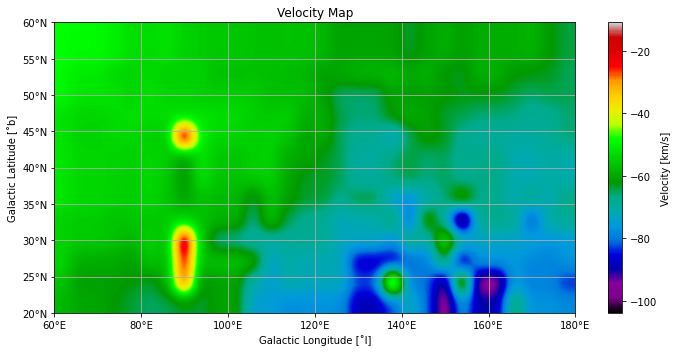

In [109]:
def add_degree_N(x, pos):
    return f"{int(x)}°N"

def add_degree_E(x, pos):
    return f"{int(x)}°E"

fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(matrix, 
               interpolation='gaussian',
               extent=[60, 180, 20, 60], 
               cmap='nipy_spectral',
               aspect='auto',
               origin='lower',
               vmin=np.amin(velocity_peak_kms), 
               vmax=np.amax(velocity_peak_kms))


cbar = fig.colorbar(im, ax=ax, label='Velocity [km/s]')
ax.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
ax.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
ax.set_xlabel('Galactic Longitude [˚l]')
ax.set_ylabel('Galactic Latitude [˚b]')
ax.set_title('Velocity Map')
plt.tight_layout()
plt.grid(True)
plt.show()

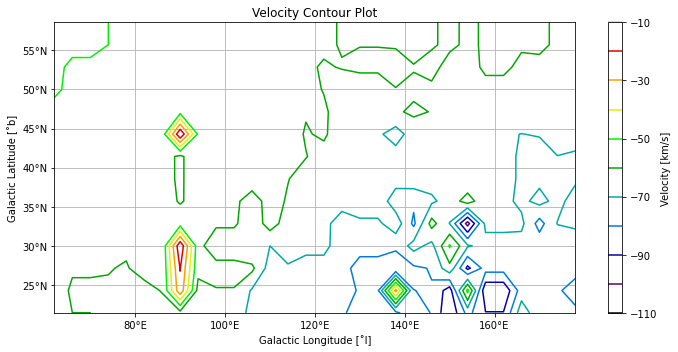

In [107]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.contour(matrix_contour, 
               levels = 9,
               extent=[60, 180, 20, 60], 
               cmap='nipy_spectral',
               origin='lower',
               vmin=np.amin(velocity_peak_kms), 
               vmax=np.amax(velocity_peak_kms))

cbar = fig.colorbar(im, ax=ax, label='Velocity [km/s]')
ax.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
ax.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
ax.set_xlabel('Galactic Longitude [˚l]')
ax.set_ylabel('Galactic Latitude [˚b]')
ax.set_title('Velocity Contour Plot')
plt.tight_layout()
plt.grid(True)
plt.show()

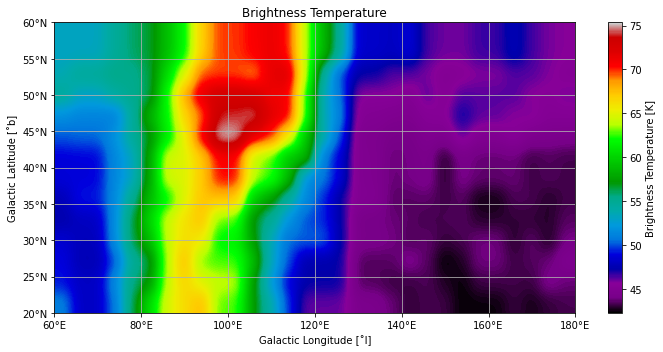

In [110]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(matrix_brightness, 
               interpolation='gaussian',
               extent=[60, 180, 20, 60], 
               cmap='nipy_spectral',
               aspect='auto',
               origin='lower',
               vmin=np.amin(temp_peaks), 
               vmax=np.amax(temp_peaks))


cbar = fig.colorbar(im, ax=ax, label='Brightness Temperature [K]')
ax.xaxis.set_major_formatter(FuncFormatter(add_degree_E))
ax.yaxis.set_major_formatter(FuncFormatter(add_degree_N))
ax.set_xlabel('Galactic Longitude [˚l]')
ax.set_ylabel('Galactic Latitude [˚b]')
ax.set_title('Brightness Temperature')
plt.tight_layout()
plt.grid(True)
plt.show()